In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

latency_func = {}
coef_dict = {}

# def fit_mm1_model(df, svc_name, ep_str, cid, y_col_name="xt"):
#     x_col = [col for col in df.columns if col != y_col_name][0]  # Assume only one x_col (rps column)
    
#     df[x_col] = pd.to_numeric(df[x_col], errors='coerce')
#     df = df.dropna(subset=[x_col])
#     df['utilization'] = df[x_col] / df[x_col].max()
#     u_ = df['utilization']
#     y_ = df[y_col_name]
#     if np.isinf(u_).any() or np.isnan(u_).any():
#         print("Infinite or NaN values found in utilization.")
#     max_rps = df[x_col].max()
#     norm_u_ = u_ * max_rps
#     constant = 1.08
#     def mm1_model(u, a, b):
#         return a / (constant - u) + b
#     popt, pcov = curve_fit(mm1_model, u_, y_, maxfev=10000)
#     print(f"Model parameters: a = {popt[0]}, b = {popt[1]}")
#     plt.figure()
#     plt.scatter(norm_u_, y_, color='red', alpha=0.1, label='Data')
#     u_plot = np.linspace(u_.min(), constant * u_.max(), 100)
#     norm_u_plot = u_plot * max_rps
#     y_plot = mm1_model(u_plot, *popt)
#     label = f'$\\frac{{{popt[0]:.2f}}}{{{constant:.2f} - u}} + {popt[1]:.2f}$'
#     plt.plot(norm_u_plot, y_plot, 'r-', label=label)
#     plt.xlabel("Normalized RPS")
#     plt.ylabel(f"{y_col_name} (ms)")
#     plt.title(f"{ep_str} in {cid}")
#     plt.legend()
#     pdf_fn = f"mm1-{svc_name}-{y_col_name}.pdf"
#     plt.savefig(pdf_fn)
#     print(f"**output: {pdf_fn}")
#     plt.show()
#     return {'a': popt[0], 'b': popt[1]}

def fit_mm1_model(df, svc_name, ep_str, cid):
    rps_list = df["rps"].tolist()
    exclusive_time_list = df["xt"].tolist()
    max_rps = df["rps"].max()
    constant = 1.05 * max_rps
    def mm1_model(u, a, b):
        return (a / (constant - u)) + b
    popt, pcov = curve_fit(mm1_model, df["rps"], exclusive_time_list, maxfev=10000)
    print(f"max_rps: {max_rps}")
    print(f"popt = {popt}")
    
    
    u_plot = np.linspace(min(df["rps"]), constant, 100)  # Avoid division by zero at u=1
    y_plot = mm1_model(u_plot, *popt)
    plt.figure()
    plt.scatter(rps_list, exclusive_time_list, color='red', alpha=0.1, label='Data')
    plt.plot(u_plot, y_plot, 'r-', label=f'MM1 Fit: $\\frac{{a}}{{c-u}}+b$\n$a={popt[0]:.2f}, c={constant:.2f}, b={popt[1]:.2f}$', color='green')
    plt.ylim(0, 500)
    plt.xlabel('Utilization (u_)')
    plt.ylabel("exclusive time (ms)")
    plt.title(f'{ep_str} in {cid}')
    plt.legend()
    pdf_fn = f"mm1-{svc_name}.pdf"
    plt.savefig(pdf_fn)
    plt.show()
    print(f"Output plot saved as: {pdf_fn}")
    return {'a': popt[0]}


def fit_polynomial_regression(df, svc_name, ep_str, cid, degree):
    rps_list = df["rps"].tolist()
    exclusive_time_list = df["xt"].tolist()
    temp = np.array([x**degree for x in rps_list]).reshape(-1, 1)  # Reshape to 2D
    X_transformed = np.hstack((temp, np.ones((len(rps_list), 1))))
    model = LinearRegression(fit_intercept=False)
    model.fit(X_transformed, exclusive_time_list)
    print(f"model.coef_, {model.coef_}")
    
    plt.figure()
    label = f'${model.coef_[0]} \cdot x^{degree} + {model.coef_[1]}$'
    plt.scatter(rps_list, exclusive_time_list, color='red', alpha=0.1, label='Data')
    X_plot = np.linspace(np.min(rps_list), np.max(rps_list), 100).reshape(-1, 1)
    X_plot_transformed = np.hstack((X_plot**degree, np.ones(X_plot.shape)))
    y_plot = model.predict(X_plot_transformed)
    plt.plot(X_plot, y_plot, linewidth=1, label=label)
    plt.ylim(0, 500)
    plt.xlabel("rps_dict")
    plt.ylabel("Exclusive time (ms)")
    plt.title(f'{ep_str} in {cid}')
    plt.legend()
    pdf_fn = f"poly-{svc_name}-xt.pdf"
    plt.savefig(pdf_fn)
    print(f"**output: {pdf_fn}")
    plt.show()

def train_latency_function_with_trace(model, df, degree):
    for cid in df["cluster_id"].unique():
        if cid == "us-west-1":
            cid_df = df[df["cluster_id"]==cid]
            for svc_name in cid_df["svc_name"].unique():
                cid_svc_df = cid_df[cid_df["svc_name"]==svc_name]
                if svc_name not in latency_func:
                    latency_func[svc_name] = dict()
                if svc_name not in coef_dict:
                    coef_dict[svc_name] = dict()
                for ep_str in cid_svc_df["endpoint_str"].unique():
                    ep_df = cid_svc_df[cid_svc_df["endpoint_str"]==ep_str]
                    if model == "poly":
                        coef_dict[svc_name][ep_str] = fit_polynomial_regression(ep_df, svc_name, ep_str, cid, degree)
                    elif model == "mm1":
                        coef_dict[svc_name][ep_str] = fit_mm1_model(ep_df, svc_name, ep_str, cid)
                    else:
                        print(f"ERROR: model: {model}")
                        assert False
    return coef_dict

In [16]:
fn = "checkout-profile-30bg-replicated-e-c-s-trace.csv"
# fn = "trace.csv"
df = pd.read_csv(fn, header=None)
df.columns = ["cluster_id","svc_name","method","path","trace_id","span_id","parent_span_id","st","et","rt","xt","ct","call_size","inflight_dict","rps_dict"]
df["endpoint_str"] = df["svc_name"] + "@" + df["method"] + "@" + df["path"]
def get_rps(df):
    df["rps"] = df["rps_dict"].apply(lambda x: int(x.split(":")[1].split("|")[0]))
    # checkoutservice@POST@/hipstershop.CheckoutService/PlaceOrder:600|	
    return df
df = get_rps(df)
df

,cluster_id,svc_name,method,path,trace_id,span_id,parent_span_id,st,et,rt,xt,ct,call_size,inflight_dict,rps_dict,endpoint_str,rps
0,us-central-1,shippingservice,POST,/hipstershop.ShippingService/ShipOrder,0006a481c8ab21ff3418c551ae4e909b,56ee67ad72400ab8,936b0db728688ae4,20.0,21.0,1.0,1.0,1.0,-1,shippingservice@POST@/hipstershop.ShippingServ...,shippingservice@POST@/hipstershop.ShippingServ...,shippingservice@POST@/hipstershop.ShippingServ...,404
1,us-central-1,checkoutservice,POST,/hipstershop.CheckoutService/PlaceOrder,0006a481c8ab21ff3418c551ae4e909b,936b0db728688ae4,7a8186eb177a8c45,3.0,28.0,25.0,20.0,25.0,-1,checkoutservice@POST@/hipstershop.CheckoutServ...,checkoutservice@POST@/hipstershop.CheckoutServ...,checkoutservice@POST@/hipstershop.CheckoutServ...,408
2,us-central-1,frontend,POST,/cart/checkout,0006a481c8ab21ff3418c551ae4e909b,7a8186eb177a8c45,3418c551ae4e909b,2.0,44.0,42.0,10.0,42.0,-1,frontend@POST@/cart/checkout:0|,frontend@POST@/cart/checkout:408|,frontend@POST@/cart/checkout,408
3,us-central-1,cartservice,POST,/hipstershop.CartService/GetCart,0006a481c8ab21ff3418c551ae4e909b,f1230613da048e69,936b0db728688ae4,5.0,8.0,3.0,3.0,3.0,-1,cartservice@POST@/hipstershop.CartService/GetC...,cartservice@POST@/hipstershop.CartService/GetC...,cartservice@POST@/hipstershop.CartService/GetCart,404
4,us-central-1,sslateingress,POST,/cart/checkout,0006a481c8ab21ff3418c551ae4e909b,3418c551ae4e909b,NaN,0.0,46.0,46.0,4.0,46.0,-1,sslateingress@POST@/cart/checkout:0|,sslateingress@POST@/cart/checkout:432|,sslateingress@POST@/cart/checkout,432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265403,us-west-1,cartservice,POST,/hipstershop.CartService/GetCart,ffeab275f1178bc3215f215c0250ef69,c02ccbfb1d3dc43d,320bfa1e876825f8,5.0,7.0,2.0,2.0,2.0,-1,cartservice@POST@/hipstershop.CartService/GetC...,cartservice@POST@/hipstershop.CartService/GetC...,cartservice@POST@/hipstershop.CartService/GetCart,404
265404,us-west-1,emailservice,POST,/hipstershop.EmailService/SendOrderConfirmation,ffeab275f1178bc3215f215c0250ef69,05adc37afd9ef7c8,320bfa1e876825f8,21.0,22.0,1.0,1.0,1.0,-1,emailservice@POST@/hipstershop.EmailService/Se...,emailservice@POST@/hipstershop.EmailService/Se...,emailservice@POST@/hipstershop.EmailService/Se...,404
265405,us-west-1,sslateingress,POST,/cart/checkout,ffeab275f1178bc3215f215c0250ef69,215f215c0250ef69,NaN,0.0,38.0,38.0,3.0,38.0,-1,sslateingress@POST@/cart/checkout:0|,sslateingress@POST@/cart/checkout:412|,sslateingress@POST@/cart/checkout,412
265406,us-west-1,checkoutservice,POST,/hipstershop.CheckoutService/PlaceOrder,ffeab275f1178bc3215f215c0250ef69,320bfa1e876825f8,7961c6a014915693,2.0,23.0,21.0,18.0,21.0,-1,checkoutservice@POST@/hipstershop.CheckoutServ...,checkoutservice@POST@/hipstershop.CheckoutServ...,checkoutservice@POST@/hipstershop.CheckoutServ...,408


model.coef_, [3.46464425e-06 5.78832963e-01]
**output: poly-shippingservice-xt.pdf


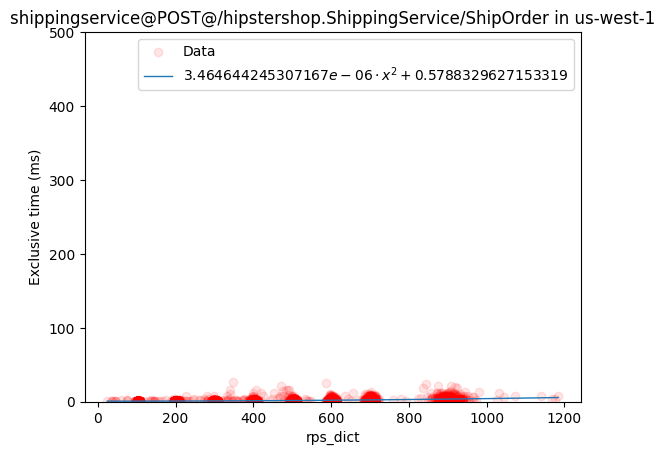

model.coef_, [ 1.34380932e-04 -5.59251021e+00]
**output: poly-checkoutservice-xt.pdf


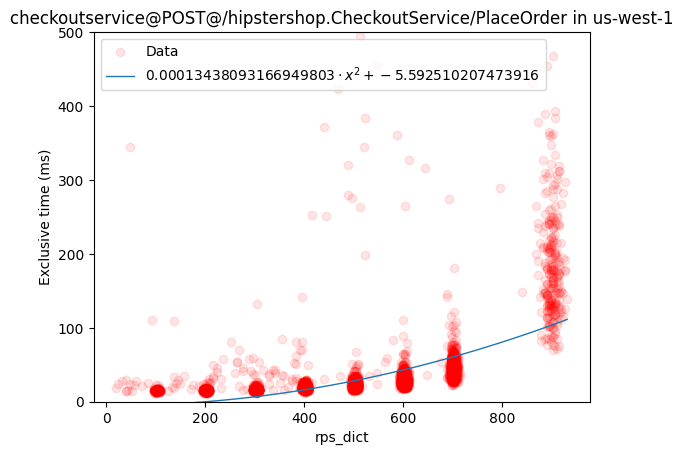

model.coef_, [3.73803073e-05 2.13414091e-01]
**output: poly-frontend-xt.pdf


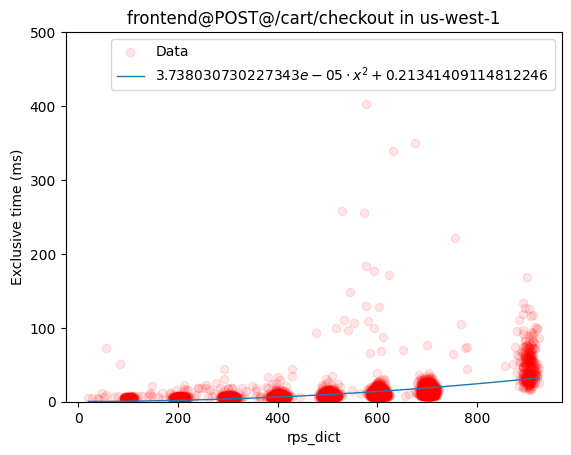

model.coef_, [8.91479265e-06 9.38488332e-01]
**output: poly-cartservice-xt.pdf


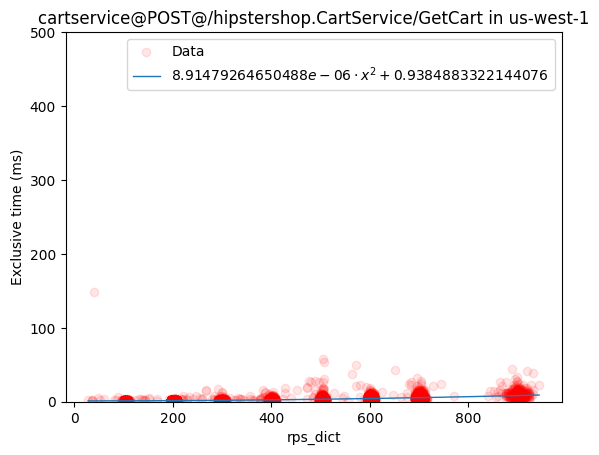

model.coef_, [1.60406856e-05 1.24542906e+00]
**output: poly-sslateingress-xt.pdf


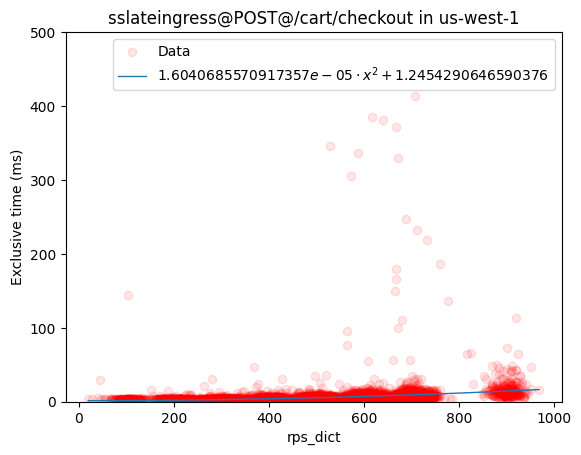

model.coef_, [5.51187394e-06 7.17715863e-01]
**output: poly-paymentservice-xt.pdf


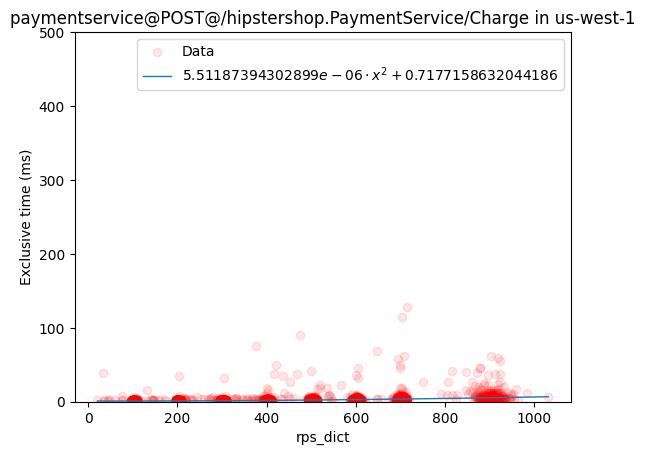

model.coef_, [ 9.58276715e-05 -1.48301086e+01]
**output: poly-recommendationservice-xt.pdf


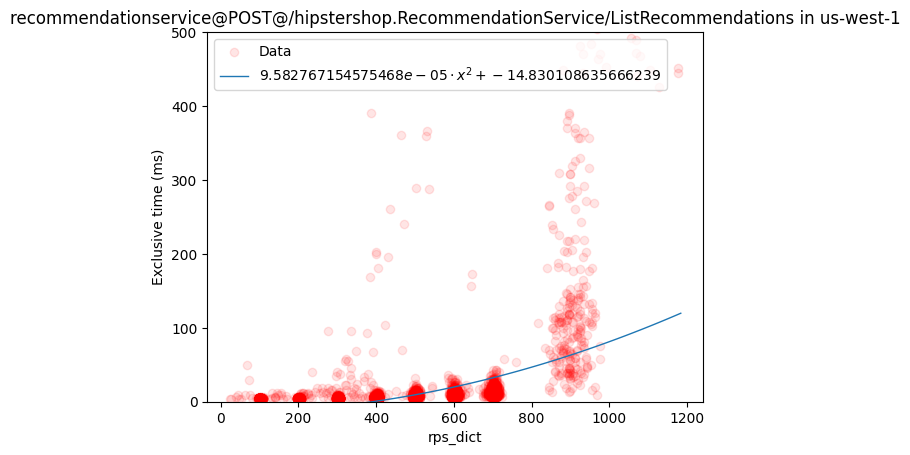

model.coef_, [6.20886543e-06 6.55468774e-01]
**output: poly-emailservice-xt.pdf


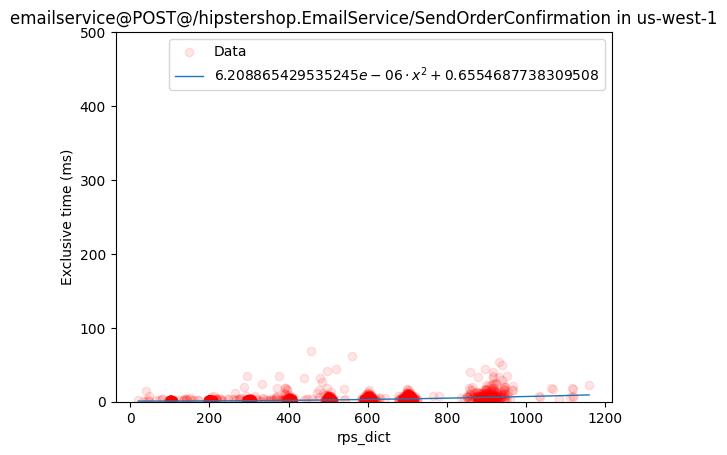

{'shippingservice': {'shippingservice@POST@/hipstershop.ShippingService/ShipOrder': None},
 'checkoutservice': {'checkoutservice@POST@/hipstershop.CheckoutService/PlaceOrder': None},
 'frontend': {'frontend@POST@/cart/checkout': None},
 'cartservice': {'cartservice@POST@/hipstershop.CartService/GetCart': None},
 'sslateingress': {'sslateingress@POST@/cart/checkout': None},
 'paymentservice': {'paymentservice@POST@/hipstershop.PaymentService/Charge': None},
 'recommendationservice': {'recommendationservice@POST@/hipstershop.RecommendationService/ListRecommendations': None},
 'emailservice': {'emailservice@POST@/hipstershop.EmailService/SendOrderConfirmation': None}}

In [13]:
train_latency_function_with_trace("poly", df, degree=2)

max_rps: 1184
popt = [ 1.19128837e+03 -1.49013649e-01]


/tmp/ipykernel_4020810/357084098.py:50: RuntimeWarning: divide by zero encountered in divide
  return (a / (constant - u)) + b


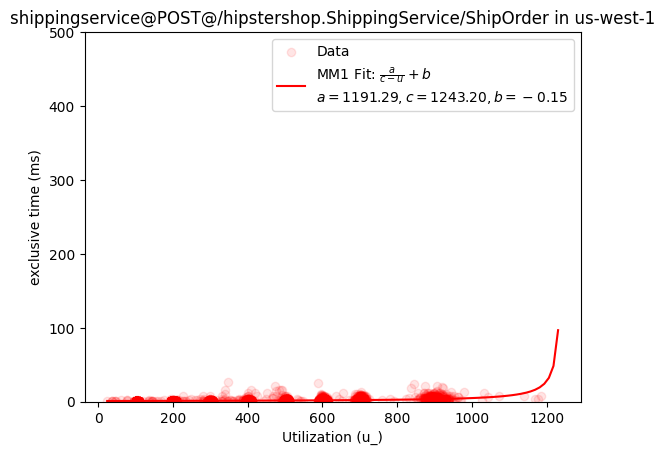

Output plot saved as: mm1-shippingservice.pdf
max_rps: 932
popt = [ 1.38524107e+04 -3.49833091e+00]


/tmp/ipykernel_4020810/357084098.py:50: RuntimeWarning: divide by zero encountered in divide
  return (a / (constant - u)) + b


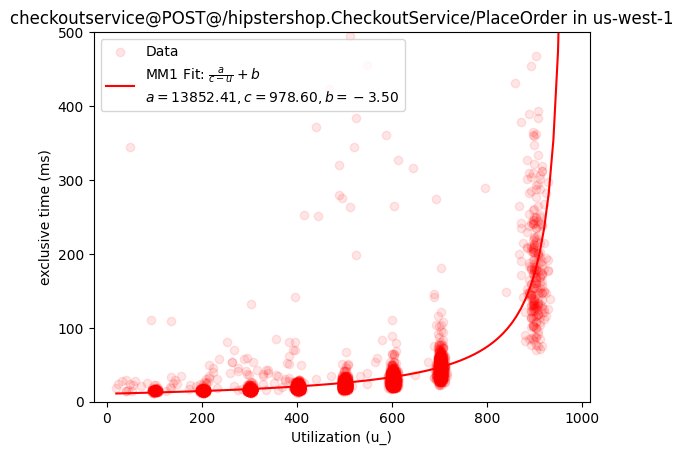

Output plot saved as: mm1-checkoutservice.pdf
max_rps: 924
popt = [3.11904907e+03 2.42076596e+00]


/tmp/ipykernel_4020810/357084098.py:50: RuntimeWarning: divide by zero encountered in divide
  return (a / (constant - u)) + b


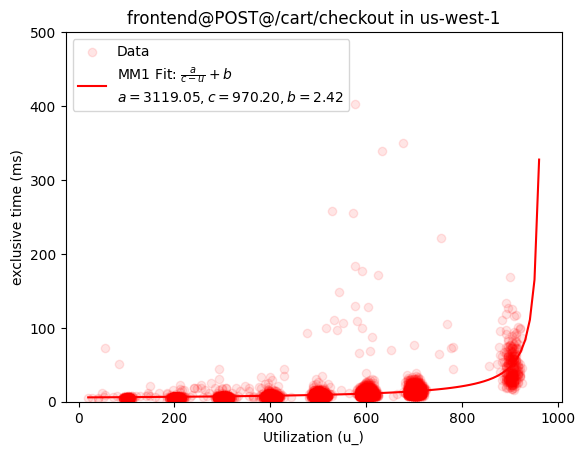

Output plot saved as: mm1-frontend.pdf
max_rps: 944
popt = [845.91523442   1.38344679]


/tmp/ipykernel_4020810/357084098.py:50: RuntimeWarning: divide by zero encountered in divide
  return (a / (constant - u)) + b


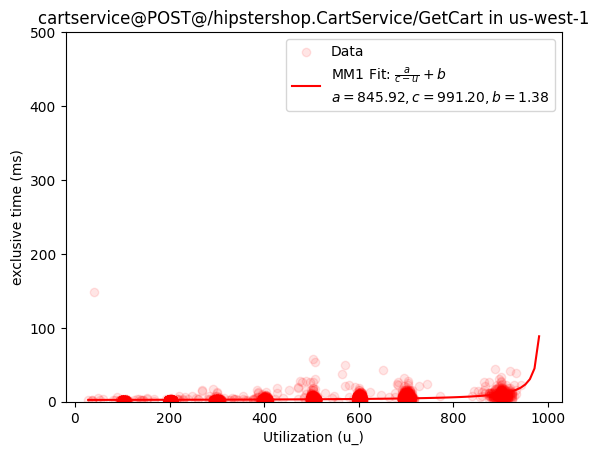

Output plot saved as: mm1-cartservice.pdf
max_rps: 968
popt = [1.88018928e+03 1.52032941e+00]


/tmp/ipykernel_4020810/357084098.py:50: RuntimeWarning: divide by zero encountered in divide
  return (a / (constant - u)) + b


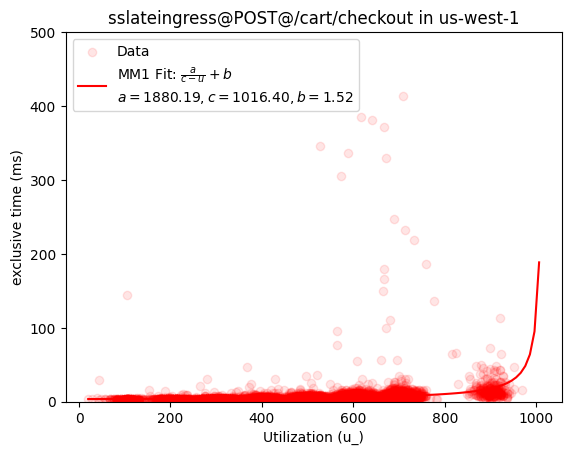

Output plot saved as: mm1-sslateingress.pdf
max_rps: 1032
popt = [ 1.28472730e+03 -1.91650428e-01]


/tmp/ipykernel_4020810/357084098.py:50: RuntimeWarning: divide by zero encountered in divide
  return (a / (constant - u)) + b


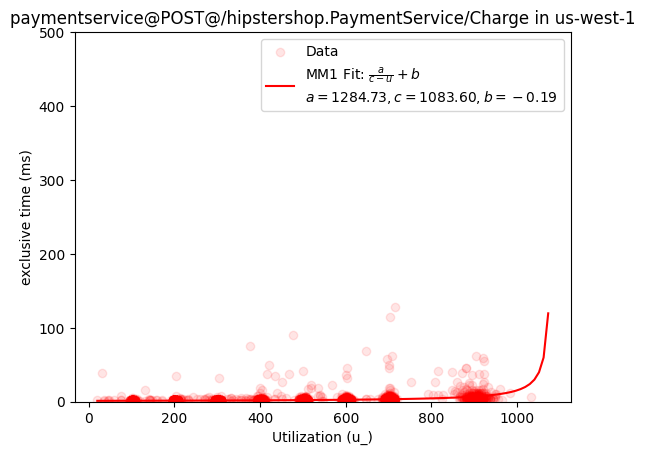

Output plot saved as: mm1-paymentservice.pdf
max_rps: 1184
popt = [45010.05791799   -52.67779265]


/tmp/ipykernel_4020810/357084098.py:50: RuntimeWarning: divide by zero encountered in divide
  return (a / (constant - u)) + b


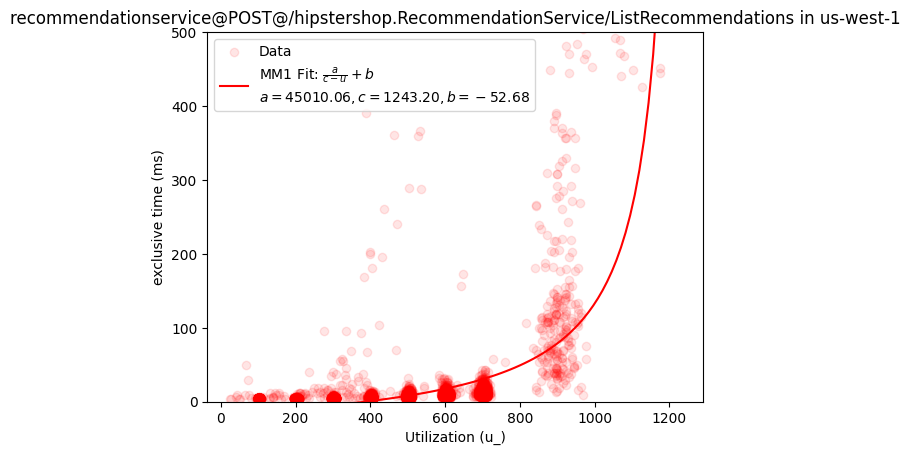

Output plot saved as: mm1-recommendationservice.pdf
max_rps: 1160
popt = [ 2.27463308e+03 -9.90985508e-01]


/tmp/ipykernel_4020810/357084098.py:50: RuntimeWarning: divide by zero encountered in divide
  return (a / (constant - u)) + b


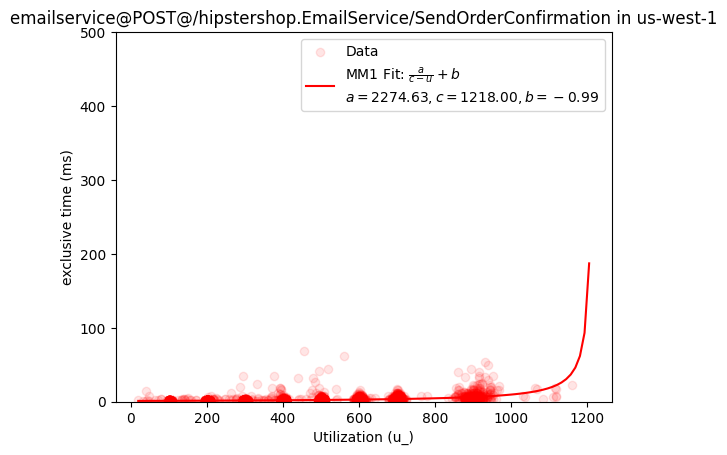

Output plot saved as: mm1-emailservice.pdf


In [17]:
mm1_coef_dict = train_latency_function_with_trace("mm1", df, degree=None)